<h2> Convolutional Neural Network for Fashion MNIST Classification</h2>

In [1]:
#!pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import matplotlib
from time import sleep
from tqdm import tqdm

In [2]:
# Define the function for plotting the channels
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
# Plot outputs as rows and inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin = w_min, vmax = w_max, cmap = 'seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [3]:
# Define the function for plotting the parameters
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            
            # Set the label for the subplot
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [4]:
# Define the function for plotting the activations
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the subplot
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [5]:
# Define the function for plotting data samples as images
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<!--Empty Space for separating topics-->


In [6]:
# Creating a transform to resize the image and convert it to a tensor
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [7]:
# Create the training and validation datasets, and apply the transformation
train_dataset = dsets.FashionMNIST(root = './data', train = True, download = True, transform = composed)
validation_dataset = dsets.FashionMNIST(root = './data', train = False, download = True, transform = composed)

0


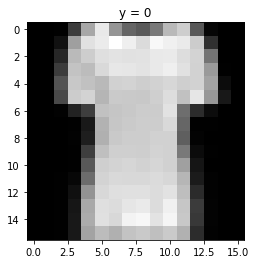

In [8]:
# Print an element label with the corresponding image
i = 10
print(train_dataset[i][1])
show_data(train_dataset[i])

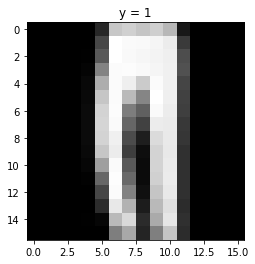

In [9]:
# Produce figures for first 3 validation set elements:
for i in range(3):
    vfig = show_data(validation_dataset[i])
    plt.savefig('val_plot %s.pdf' % i)

<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [10]:
# Build the convolutional neural network class
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1 = 16, out_2 = 32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1=nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool2=nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each step
    def activations(self, x):
        
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out1, out

In [11]:
# Create the model object using CNN class, choosing the number of outputs for the first and second concolutional layers
model = CNN(out_1 = 16, out_2 = 32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


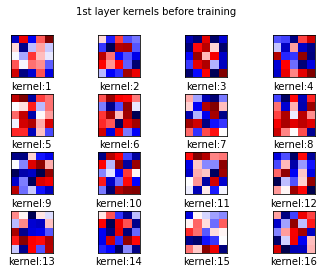

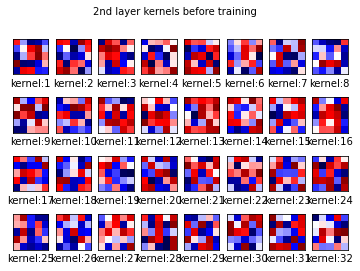

In [12]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader


In [13]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 5000)

In [14]:
# Train the model

n_epochs = 30
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)
COST = 0

def train_model(n_epochs):
    for epoch in tqdm(range(n_epochs)):
        #print('Current epoch is', epoch, end='\r')
        sleep(10)
        
        COST = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.data
        cost_list.append(COST)
        
        correct = 0
        # Perform a prediction on the validation data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
train_model(n_epochs)

100%|██████████| 30/30 [15:20<00:00, 30.69s/it]


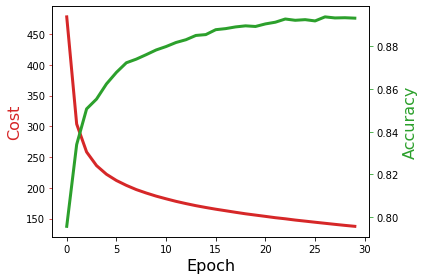

In [15]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
cl1 = 'tab:red'
ax1.plot(cost_list, color = cl1, linewidth = 3)
ax1.set_xlabel('Epoch', fontsize = 16)
ax1.set_ylabel('Cost', color = cl1, fontsize = 16)
ax1.tick_params(axis = 'y', color = cl1)
    
ax2 = ax1.twinx()  
cl2 = 'tab:green'
ax2.plot(accuracy_list, color = cl2, linewidth = 3)
ax2.set_ylabel('Accuracy', color = cl2, fontsize = 16) 
ax2.tick_params(axis = 'y', color = cl2)
fig.tight_layout()

plt.savefig('CNN_FashionMNIST_perf.pdf')

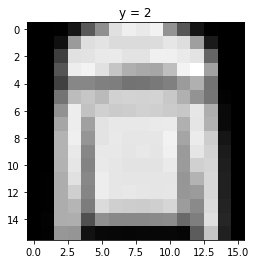

In [16]:
# Choose and element from the dataset
j = 5
show_data(train_dataset[j])

In [17]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[j][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

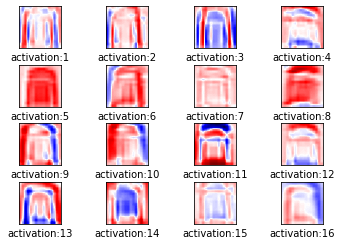

In [18]:
# Plot the outputs after the first convolution
plot_activations(out[0], number_rows = 4, name = "Output after the 1st CNN")

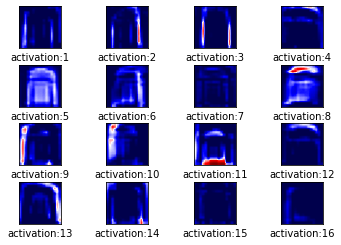

In [19]:
# Plot the outputs after the first Relu activation
plot_activations(out[1], number_rows = 4, name = "Output after the 1st Relu")

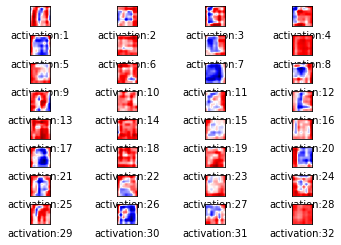

In [20]:
# Plot the outputs after the second convolution
plot_activations(out[2], number_rows = 32 // 4, name = "Output after the 2nd CNN")

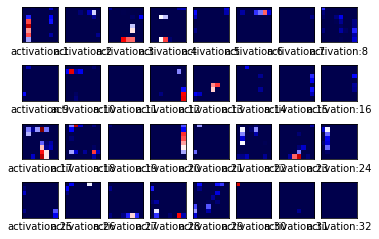

In [21]:
# Plot the outputs after the second Relu activation
plot_activations(out[3], number_rows = 4, name = "Output after the 2nd Relu")

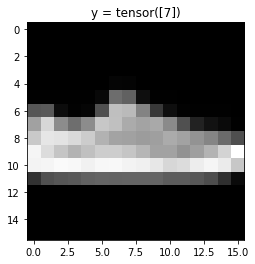

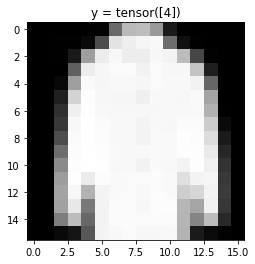

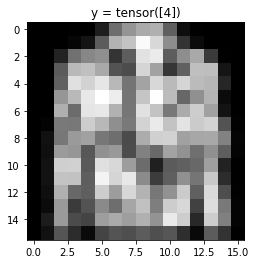

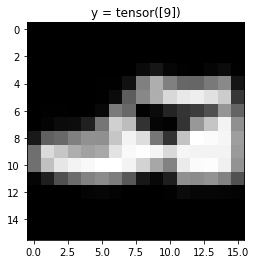

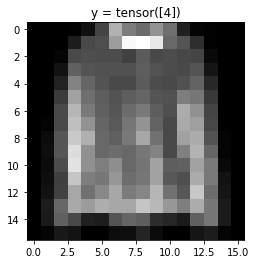

In [22]:
# Plot the first 5 misclassified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        #print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

<!--Empty Space for separating topics-->
